# Exploring cosmological simulations with CosmoSim
## Introduction to job handling with uws-client

CosmoSim is a web application available at http://www.cosmosim.org/ where data from cosmological simulations is available. This includes catalogues of dark matter halos (clusters) and galaxies for different time steps during the evolution of the simulated universe, merging information, substructure data, density fields and more.

In this tutorial, we will use the [uws-client](https://github.com/aipescience/uws-client) for connecting with CosmoSim's UWS-interface for seeing your list of jobs, sending jobs and retrieving results.

## Imports
Import the necessary libraries and the UWS module from the uws-client:

In [212]:
# load astropy for reading VOTABLE format
from astropy.io.votable import parse_single_table

# import matplotlib for plotting results
import matplotlib.pyplot as plt

In [213]:
# import sys
# sys.path.append('<your own path>/uws-client')

from uws import UWS

## Setup the connection

The URL for connecting with CosmoSim's uws-client is 'https://www.cosmosim.org/uws/query/'. You also need to define your username and password, either by inserting it directly below or by saving your credentials in a local cosmosim-user.json file and reading it here. The credentials are the same as on the CosmoSim webpage. If you do not have an account yet, please register at [CosmoSim registration](https://www.cosmosim.org/auth/registration/register). Alternatively, you can use the user `uwstest` with password `gavo` for testing purposes. (Be aware that anyone can use this user and delete your results at any time!)


In [17]:
# set credentials here:
# username = 'uwstest'
# password = 'gavo'

# or read your own username and password from a json-file,
# format: { "username": "<yourname>", "password": "<your password>" }
import json
with open('cosmosim-user.json') as credentials_file:    
    username, password = json.load(credentials_file).values()

url = 'https://www.cosmosim.org/uws/query/'
c = UWS.client.Client(url, username, password)

## List previous jobs
Once the connection is set up, you can retrieve the list of previously run jobs with `c.get_job_list()`. You can also provide extra filters for the job list, e.g. filtering by phase or creation time of the job or just output the most recent ones using the `last` keyword.

In [67]:
filters = {'phases': ['PENDING', 'COMPLETED', 'ERROR'], 'last': 5}
jobs = c.get_job_list(filters)

# printing the returned resulting jobs-object gives a list of jobs
print jobs

Job '1489393683792045078' in phase 'PENDING' created at '2017-03-13T09:28:03+01:00' - https://www.cosmosim.org/uws/query/1489393683792045078
Job '1489390719480540687' in phase 'ERROR' created at '2017-03-13T08:38:39+01:00' - https://www.cosmosim.org/uws/query/1489390719480540687
Job '1489158214227556580' in phase 'COMPLETED' created at '2017-03-10T16:03:34+01:00' - https://www.cosmosim.org/uws/query/1489158214227556580
Job '1489158153978380359' in phase 'COMPLETED' created at '2017-03-10T16:02:33+01:00' - https://www.cosmosim.org/uws/query/1489158153978380359
Job '1489158094195514088' in phase 'COMPLETED' created at '2017-03-10T16:01:34+01:00' - https://www.cosmosim.org/uws/query/1489158094195514088



For each job, its unique id, ownerId, creationTime and phase are stored within this job list. 
At CosmoSim, we store the table name as the `runId` for each job. If no table name was given during job creation, the current timestamp is used.

In [30]:
print "# jobId, ownerId, creationTime, phase, runId:"
for job in jobs.job_reference:
    print job.id, job.ownerId, job.creationTime, job.phase[0], job.runId

# jobId, ownerId, creationTime, phase, runId:
1489158214227556580 uwstest 2017-03-10T16:03:34+01:00 COMPLETED 2017-03-10-16-03-34-2251
1489158153978380359 uwstest 2017-03-10T16:02:33+01:00 COMPLETED 2017-03-10-16-02-33-9759
1489158094195514088 uwstest 2017-03-10T16:01:34+01:00 COMPLETED 2017-03-10-16-01-34-1929
1489158062282761682 uwstest 2017-03-10T16:01:02+01:00 COMPLETED 2017-03-10-16-01-02-2808
1489158030472308573 uwstest 2017-03-10T16:00:30+01:00 COMPLETED 2017-03-10-16-00-30-4699


## Create, check and run a job

For creating a new job, first define the necessary parameters. For CosmoSim this is `query`, which is the SQL string and the optional parameters `queue` (long or short) and `table` (a unique table name). We set here an SQL query that will select the 10 most massive clusters from the MDPL2 simulation, Rockstar catalog.

In [71]:
parameters = {'query': 
              'SELECT rockstarId, x,y,z, Mvir FROM MDPL2.Rockstar'\
                + ' WHERE snapnum=125 ORDER BY Mvir DESC LIMIT 10',
              'queue': 'short'}

Now **create a new job** with these parameters:

In [72]:
job = c.new_job(parameters)

And print the job's id and phase:

In [73]:
print job.job_id, job.phase[0]

1489393922402608701 PENDING


The job is created now, but it is not started yet - you can still adjust its parameters with c.set_parameters_job. E.g. let's change the queue to long:

In [74]:
update_params = {'queue': 'long'}
job = c.set_parameters_job(job.job_id, update_params)

Print the parameters to check this:

In [75]:
for p in job.parameters:
    print p.id, p.value

queue long
query SELECT rockstarId, x,y,z, Mvir FROM MDPL2.Rockstar WHERE snapnum=125 ORDER BY Mvir DESC LIMIT 10


Now **start the job**, i.e. put it into the job queue using `run_job`:

In [76]:
run = c.run_job(job.job_id)
print run.job_id

1489393922402608701


The job should now also be visible in the web interface, at the Query Interface, left side, under 'Jobs'.  
Let's check the job's phase: 

In [77]:
job = c.get_job(run.job_id)
print job.phase[0]


QUEUED


You can also use the `wait` parameter to wait at most the specified number of seconds until the phase has changed:

In [78]:
job = c.get_job(run.job_id, '10', 'QUEUED')
print job.phase[0]

COMPLETED


Repeat the step above using "EXECUTING" as job phase until the job phase is "COMPLETED".

In [191]:
job = c.get_job(run.job_id, '10', 'EXECUTING')
print job.phase[0]

COMPLETED


## Get the results

Once your job is in "COMPLETED" phase, you can retrieve the results.

Print the job result entries:

In [192]:
for r in job.results:
    print r

Result id 'csv' reference: https://www.cosmosim.org/query/download/stream/table/2017-03-13-09-32-13-6377/format/csv
Result id 'votable.xml' reference: https://www.cosmosim.org/query/download/stream/table/2017-03-13-09-32-13-6377/format/votable
Result id 'votableB1.xml' reference: https://www.cosmosim.org/query/download/stream/table/2017-03-13-09-32-13-6377/format/votableB1
Result id 'votableB2.xml' reference: https://www.cosmosim.org/query/download/stream/table/2017-03-13-09-32-13-6377/format/votableB2


With `r.reference` you can access the URL of each result. Let's download the results in VOTABLE format:

In [193]:
fileurl = str(job.results[1].reference)
resultfilename = "result.xml"
success = c.connection.download_file(fileurl, username, password, file_name=resultfilename)
if not success:
    print "File could not be downloaded, please check the job phase and result urls."
else:
    print "File downloaded successfully."

File downloaded successfully.


Since there is only one table, we can quickly read the VOTABLE into a numpy array using astropy:

In [194]:
table = parse_single_table(resultfilename, pedantic=False)
data = table.array

Print the results row by row:

In [195]:
print data

[ (1, 12663401752, 669.8790283203125, 197.093994140625, 960.0079956054688, 3502699911839744.0)
 (2, 12568957065, 6.296500205993652, 61.284698486328125, 512.0330200195312, 2610899881820160.0)
 (3, 12657871796, 644.135986328125, 671.8619995117188, 241.302001953125, 2464100047126528.0)
 (4, 12690066801, 915.3740234375, 140.13499450683594, 875.5419921875, 2458800057483264.0)
 (5, 12698654951, 958.1680297851562, 73.85369873046875, 974.68701171875, 2382099994640384.0)
 (6, 12690125164, 900.3259887695312, 142.45199584960938, 944.1580200195312, 2362299926970368.0)
 (7, 12636014904, 486.2460021972656, 231.9550018310547, 903.6859741210938, 2269899879612416.0)
 (8, 12577987103, 12.169500350952148, 960.385009765625, 944.1920166015625, 2244000018857984.0)
 (9, 12656411108, 606.7890014648438, 487.3819885253906, 619.7739868164062, 2154799990571008.0)
 (10, 12578986015, 121.9729995727539, 76.42739868164062, 770.2570190429688, 2027799955111936.0)]


Or print only a column:

In [196]:
print data['x']

[669.8790283203125 6.296500205993652 644.135986328125 915.3740234375
 958.1680297851562 900.3259887695312 486.2460021972656 12.169500350952148
 606.7890014648438 121.9729995727539]


Get the units for x and y values:

In [197]:
field = table.get_field_by_id('x')
unit_x = field.unit
field = table.get_field_by_id('y')
unit_y = field.unit

print "Units for x and y: ", unit_x, unit_y

Units for x and y:  Mpc / h Mpc / h


## Plot results

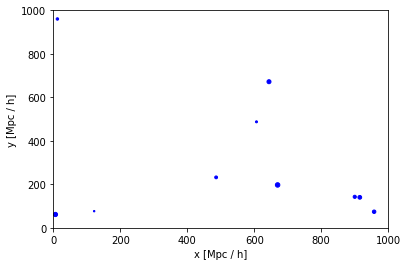

In [199]:
ax = plt.subplot(111)

# set axis labels
ax.set_xlabel('x [' + str(unit_x) + ']')
ax.set_ylabel('y [' + str(unit_y) + ']')

# set axis range
ax.set_xlim(0, 1000)
ax.set_ylim(0, 1000)

# plot data,
# using decreasing point size,
# so the biggest point is the most massive object
s = range(20,0,-2)
ax.scatter(data['x'], data['y'], s, color='b');
plt.show()

## Example: Retrieve progenitors of a halo

Let's do a more elaborate example: for the most massive dark matter halo from the previous query, get its progenitors that merged into this halo and plot their positions over time. We restrict the progenitors to those with mass > 1.e12/h solar masses.

In [201]:
most_massive_rockstarId = data[0]['rockstarId']

In [229]:
query = """
SELECT p.rockstarId, p.snapnum as snapnum, p.x as x, p.y as y, p.z as z, p.Mvir as Mvir, p.Rvir as Rvir
FROM MDPL2.Rockstar AS p,
  (SELECT depthFirstId, lastProg_depthFirstId FROM MDPL2.Rockstar
  WHERE rockstarId = """ + str(most_massive_rockstarId) + """) AS m
WHERE p.depthFirstId BETWEEN m.depthFirstId AND m.lastProg_depthFirstId
AND p.Mvir > 1.e11
ORDER BY snapnum
"""


Create and start the job:

In [230]:
job = c.new_job({'query': query})
if job.phase[0] != "PENDING":
    print "ERROR: not in pending phase!"
else:
    run = c.run_job(job.job_id)
print job.phase[0]

PENDING


Check the status and wait until it is finished (this can take a couple of minutes!!):

In [231]:
job = c.get_job(run.job_id, '60', 'QUEUED')
print "Time out or job is not in QUEUED phase anymore."
job = c.get_job(run.job_id, '60', 'EXECUTING')
print "Time out or job is not in EXECUTING phase anymore."
print "Job phase: ", job.phase[0]
print job

Time out or job is not in QUEUED phase anymore.
Time out or job is not in EXECUTING phase anymore.
Job phase:  COMPLETED
JobId : '1489409192044570091'
RunId : '2017-03-13-13-46-32-2356'
OwnerId : 'uwstest'
Phase : 'COMPLETED'
Quote : 'None'
CreationTime : '2017-03-13T13:46:32+01:00'
StartTime : '2017-03-13T13:46:33+01:00'
EndTime : '2017-03-13T13:46:33+01:00'
ExecutionDuration : '40'
Destruction : '2999-12-31T00:00:00+01:00'
Parameters :
Parameter id 'database' byRef: False is_post: False - value: cosmosim_user_uwstest
Parameter id 'table' byRef: False is_post: False - value: 2017-03-13-13-46-32-2356
Parameter id 'query' byRef: False is_post: False - value: 
SELECT p.rockstarId, p.snapnum as snapnum, p.x as x, p.y as y, p.z as z, p.Mvir as Mvir, p.Rvir as Rvir
FROM MDPL2.Rockstar AS p,
  (SELECT depthFirstId, lastProg_depthFirstId FROM MDPL2.Rockstar
  WHERE rockstarId = 12663401752) AS m
WHERE p.depthFirstId BETWEEN m.depthFirstId AND m.lastProg_depthFirstId
AND p.Mvir > 1.e11
ORDER B

Retrieve the results:

In [232]:
fileurl = str(job.results[1].reference)
resultfilename = "result.xml"
success = c.connection.download_file(fileurl, username, password, file_name=resultfilename)
if not success:
    print "File could not be downloaded, please check the job phase and result urls."
else:
    print "File downloaded successfully."

File downloaded successfully.


Plot the positions of the progenitor halos, colored by snapshot number (increasing time):

In [233]:
table = parse_single_table(resultfilename, pedantic=False)
data = table.array

field = table.get_field_by_id('x')
unit_x = field.unit
field = table.get_field_by_id('y')
unit_y = field.unit
field = table.get_field_by_id('z')
unit_z = field.unit


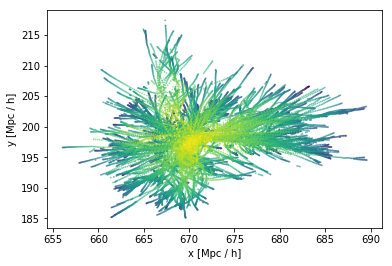

In [234]:
ax = plt.subplot(111)

# set axis labels
ax.set_xlabel('x [' + str(unit_x) + ']')
ax.set_ylabel('y [' + str(unit_y) + ']')

# set axis range
#ax.set_xlim(0, 1000)
#ax.set_ylim(0, 1000)

# plot data,
# color by snapnum, i.e. snapshot number, i.e. increasing time
ax.scatter(data['x'], data['y'], s=0.7, c=data['snapnum'], alpha=0.5);
plt.show()